In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from matplotlib import pyplot as plt 
import seaborn as sns
url = 'house_prices_with_outliers.csv'
df = pd.read_csv(url)
df.head()

,area,bedroom,price
0,1649,2,176093
1,1458,2,166568
2,1694,3,194465
3,1956,4,244831
4,1429,2,179966


In [4]:
df.isnull().sum()

area       0
bedroom    0
price      0
dtype: int64

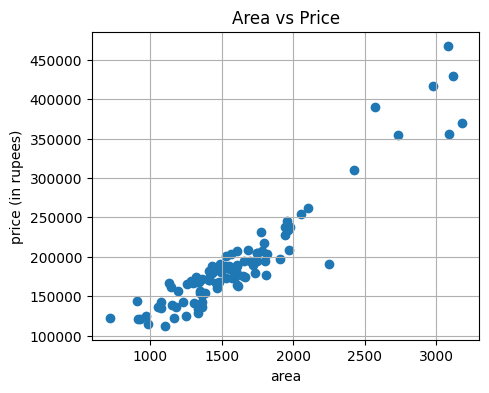

In [6]:
plt.figure(figsize=(5, 4))
plt.scatter(df['area'], df['price'])
plt.xlabel("area")
plt.ylabel("price (in rupees)")
plt.grid(True)
plt.title("Area vs Price")
plt.show()

# Insights
Area and price show a strong positive linear relationship. Larger houses consistently cost more, and the pattern is clean with no major outliers, 
making area a highly predictive feature.

<h3 style="color: blue; text-align: center;">Exploratory Data Analysis</h3>


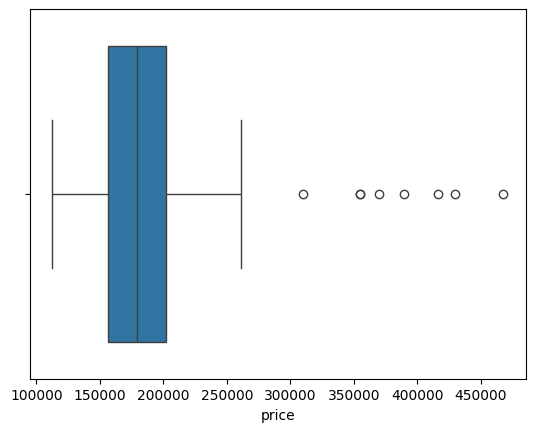

In [7]:
#now we will make boxplot to remove the outliers

sns.boxplot(x=df["price"])
plt.show()

In [8]:
def iqr_bounds(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound
    
    

In [9]:
lower_bound, upper_bound = iqr_bounds(df['price'])
upper_bound

np.float64(269592.625)

In [10]:
df.price.quantile(0.92)

np.float64(265138.67999999993)

In [11]:
quantile_thresold = df.price.quantile(0.92)
quantile_thresold

np.float64(265138.67999999993)

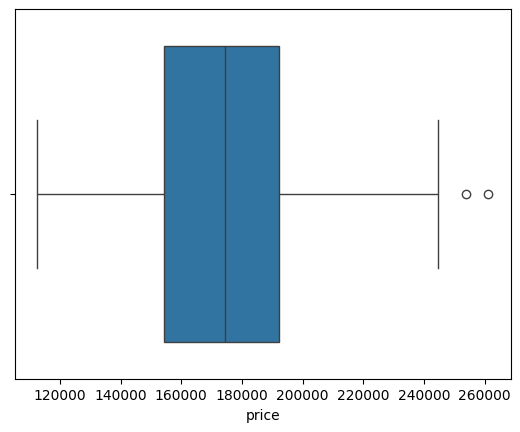

In [12]:
df = df[df["price"]<quantile_thresold]
df = df.reset_index(drop=True)
sns.boxplot(x=df["price"]) #again we crossed check with box plot if any outlers present
plt.show()

In [13]:
df.describe()

,area,bedroom,price
count,92.000000,92.000000,92.000000
mean,1485.282609,2.478261,175192.717391
std,296.272125,1.152906,32214.131117
min,714.000000,1.000000,112588.000000
25%,1319.000000,1.000000,154213.250000
50%,1471.500000,2.000000,174561.500000
75%,1667.250000,3.250000,192133.250000
max,2249.000000,5.000000,261257.000000


In [14]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['area', 'bedroom', 'price'], dtype='object')

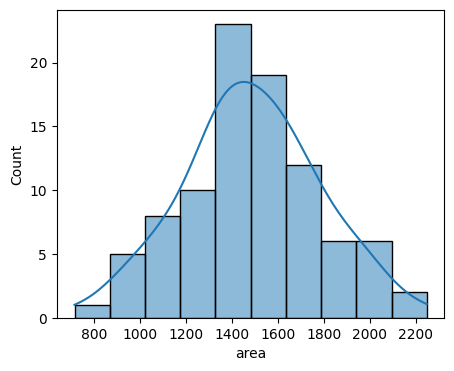

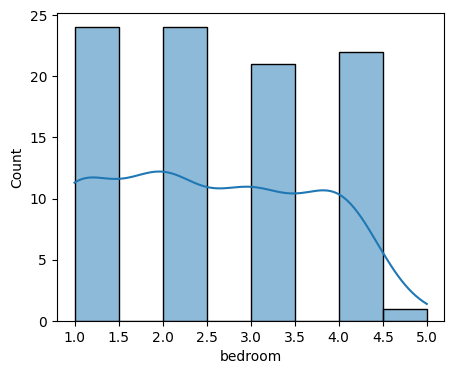

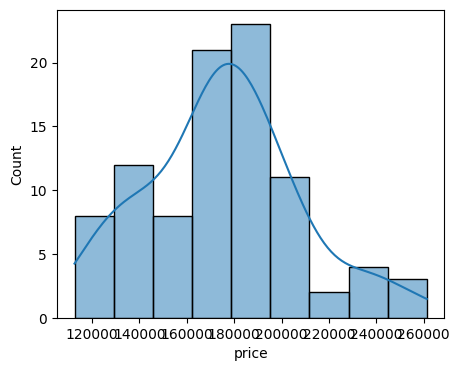

In [15]:
for col in numeric_columns:
    plt.figure(figsize=(5,4))
    sns.histplot(x=df[col], kde=True)
    plt.show()
    

# Insights
Area shows a near-normal distribution, bedrooms are evenly spread across categories, and price shows slight right-skew with a few higher values 
but no severe outliers.

In [16]:
#spiltiing the train and test data

X = df.drop(["price"], axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [17]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['area', 'bedroom']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,area,bedroom
count,92.000000,92.000000
mean,0.502464,0.369565
std,0.193011,0.288227
min,0.000000,0.000000
25%,0.394137,0.000000
50%,0.493485,0.250000
75%,0.621010,0.562500
max,1.000000,1.000000


In [28]:
##calculating variance_inflation_factor

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [19]:
calculate_vif(X)

,Column,VIF
0,area,2.20203
1,bedroom,2.20203


# Insights
1. All features have VIF values below 10, indicating no serious multicollinearity in the dataset.
2. The VIF values are within an acceptable range, so no feature needs to be dropped based on multicollinearity.

<h3 style="color: blue; text-align: center;">Model Training</h3>


We are going to check with LinearRregression and XGBRegression

In [20]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
print("train_score : ", train_score)
print("test_score : ", test_score)

train_score :  0.876847520877311
test_score :  0.8877553803423494


In [21]:
#checking accuracy
from sklearn.metrics import mean_squared_error
import numpy as np
y_predict = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_predict)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE : ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE :  69796968.14012541 RMSE:  8354.457980032303


In [22]:
##doing cross validation for further know whether our modal is overfitting or not

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_lr, X, y, cv=5, scoring='r2')
print("Cross-validated R2 scores:", scores)
print("Average R2:", scores.mean())

Cross-validated R2 scores: [0.93485303 0.89095843 0.8301749  0.92913383 0.70191457]
Average R2: 0.8574069510243852


In [23]:
##compare training vs test vs cross-validated R²:

print("Training R²:", model_lr.score(X_train, y_train))
print("Test R²:", model_lr.score(X_test, y_test))

Training R²: 0.876847520877311
Test R²: 0.8877553803423494


In [24]:
##Trying different model

In [25]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
print("train_score : ", train_score)
print("test_score : ", test_score)

train_score :  0.999999463558197
test_score :  0.7734379768371582


<h3 style="color: blue; text-align: center;"> Conclusion </h3>


1.The model performs well with an R² score of ~0.88 on the test set, indicating strong predictive capability for house price prediction.
2. This is why we are selecting Linear Regression for this task.

In [26]:
best_model = model_lr